#### Requirements

In [ ]:
!pip install datasets[audio] torchaudio_augmentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 28.0 MB/s eta 0:00:00
  Created wheel for julius: filename=julius-0.2.7-py3

## Dataset

In [ ]:
import torchaudio
from datasets import load_dataset
from torch.utils.data import Dataset


class GTZAN(Dataset):

    def __init__(self, split="train"):
        self.dataset = load_dataset("marsyas/gtzan", split=split)
        self.labels = ['blues', 'classical', 'country', 'disco', 'hiphop',
                       'jazz', 'metal', 'pop', 'reggae', 'rock']

        self.label2idx = {label: idx for idx, label in enumerate(self.labels)}
        self.n_classes = len(self.labels)

    def __getitem__(self, idx):
        file_path = self.dataset[idx]['file']
        audio, sr = torchaudio.load(file_path)
        label = self.label2idx[self.labels[self.dataset[idx]['genre']]]

        return audio, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
"""Wrapper for Torch Dataset class to enable contrastive training
"""
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torchaudio_augmentations import Compose
from typing import Tuple, List


class ContrastiveDataset(Dataset):
    def __init__(self, dataset: Dataset, input_shape: List[int], transform: Compose):
        self.dataset = dataset
        self.transform = transform
        self.input_shape = input_shape
        self.ignore_idx = []

    def __getitem__(self, idx) -> Tuple[Tensor, Tensor]:
        if idx in self.ignore_idx:
            return self[idx + 1]

        audio, label = self.dataset[idx]

        if audio.shape[1] < self.input_shape[1]:
            self.ignore_idx.append(idx)
            return self[idx + 1]

        if self.transform:
            audio = self.transform(audio)
        return audio, label

    def __len__(self) -> int:
        return len(self.dataset)

    def concat_clip(self, n: int, audio_length: float) -> Tensor:
        audio, _ = self.dataset[n]
        batch = torch.split(audio, audio_length, dim=1)
        batch = torch.cat(batch[:-1])
        batch = batch.unsqueeze(dim=1)

        if self.transform:
            batch = self.transform(batch)

        return batch

In [ ]:
import os
from torchaudio_augmentations import(ComposeMany, RandomResizedCrop)

def get_dataset(dataset):
    train_transform = [RandomResizedCrop(n_samples=59049)]
    num_augmented_samples = 1
    if dataset == "gtzan":
        d = GTZAN()
        contrastive_dataset = ContrastiveDataset(
        d,
        input_shape=(1, 59049),
        transform=ComposeMany(train_transform, num_augmented_samples)
    )
    else:
        raise NotImplementedError("Dataset not implemented")
    return contrastive_dataset

#### Dataset tests

In [ ]:
import unittest
import torch

class TestGTZAN(unittest.TestCase):
    def test_dataset(self):
        dataset = GTZAN()
        sample_idx = 0
        sample = dataset.__getitem__(sample_idx)

        # Audio waveform
        self.assertIsInstance(sample[0], torch.Tensor)

        # Label
        self.assertIsInstance(sample[1], int)

        # Audio waveform has at least 1 sample
        self.assertGreaterEqual(sample[0].shape[0], 1)

        # Label is non-negative
        self.assertGreaterEqual(sample[1], 0)
        
        # Label is less than the number of classes in the dataset
        self.assertLess(sample[1], dataset.num_classes)

In [ ]:
gtzan_test = TestGTZAN()
gtzan_test.test_dataset

<bound method TestGTZAN.test_dataset of <__main__.TestGTZAN testMethod=runTest>>

### Dataloader

In [ ]:
from torch.utils.data import DataLoader
dataset = get_dataset("gtzan")

dataloader = DataLoader(
    dataset,
    batch_size=48,
    num_workers=0,
    drop_last=True,
    shuffle=False,
)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset gtzan downloaded and prepared to /root/.cache/huggingface/datasets/marsyas___gtzan/default/0.0.0/8bd0e23c2d9b2be30d36bc6834319772dff22a3bd28527996612386cef003910. Subsequent calls will reuse this data.


#### Dataloader tests

In [ ]:
class TestDataLoader(unittest.TestCase):
    
    def test_batch_size(self):
        # set up
        dataset = get_dataset("gtzan")
        input_shape = (1, 59049)
        dataloader = DataLoader(dataset, batch_size=48, num_workers=0, drop_last=True, shuffle=False)
        
        # test
        for batch_idx, (data, target) in enumerate(dataloader):
            batch_size = data.shape[0]
            self.assertEqual(batch_size, 48, f"Batch {batch_idx} - Expected batch size: 48, Actual batch size: {batch_size}")

In [ ]:
# dataloader_test = TestDataLoader()
# dataloader_test.test_batch_size()

## Model

In [ ]:
import torch.nn as nn
import numpy as np


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

    def initialize(self, m):
        if isinstance(m, (nn.Conv1d)):
            # nn.init.xavier_uniform_(m.weight)
            # if m.bias is not None:
            #     nn.init.xavier_uniform_(m.bias)

            nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
class SampleCNN(Model):
    def __init__(self, strides):
        super(SampleCNN, self).__init__()

        self.strides = strides
        self.sequential = [
            nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
                nn.BatchNorm1d(128),
                nn.ReLU(),
            )
        ]

        self.hidden = [
            [128, 128],
            [128, 128],
            [128, 256],
            [256, 256],
            [256, 256],
            [256, 256],
            [256, 256],
            [256, 256],
            [256, 512],
        ]

        assert len(self.hidden) == len(
            self.strides
        ), "Number of hidden layers and strides are not equal"
        for stride, (h_in, h_out) in zip(self.strides, self.hidden):
            self.sequential.append(
                nn.Sequential(
                    nn.Conv1d(h_in, h_out, kernel_size=stride, stride=1, padding=1),
                    nn.BatchNorm1d(h_out),
                    nn.ReLU(),
                    nn.MaxPool1d(stride, stride=stride),
                )
            )

        # 1 x 512
        self.sequential.append(
            nn.Sequential(
                nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(512),
                nn.ReLU(),
            )
        )

        self.sequential = nn.Sequential(*self.sequential)

    def forward(self, x):
        x = x[:, 0, :]
        out = self.sequential(x)
        return out

In [ ]:
from collections import OrderedDict


def load_encoder_checkpoint(checkpoint_path: str) -> OrderedDict:
    state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if "encoder." in k:
            new_state_dict[k.replace("encoder.", "")] = v

    return new_state_dict

In [ ]:
import pickle
strides = [3, 3, 3, 3, 3, 3, 3, 3, 3]
model = SampleCNN(strides)
checkpoint_path = "clmr_checkpoint_10000.pt"
model.load_state_dict(load_encoder_checkpoint(checkpoint_path))
with open('model.pkl', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
model.eval()  # put the model in evaluation mode

all_representations = []
with torch.no_grad():
    for data, target in dataloader:
        # pass the data through the model to get representations
        representations = model(data)
        all_representations.append(representations)

all_representations = torch.cat(all_representations)
with open('representations.pkl', 'wb') as f:
  pickle.dump(all_representations, f)

In [ ]:
all_representations.shape

torch.Size([960, 512, 1])

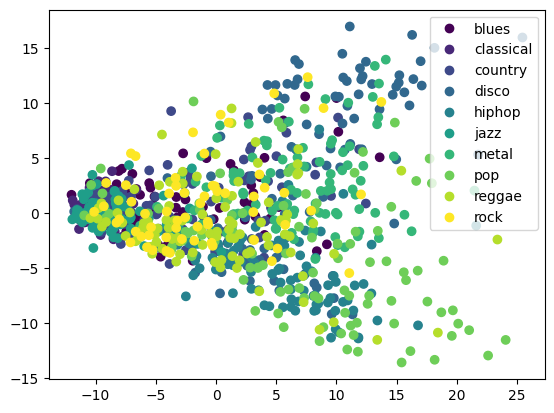

In [26]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get the labels for each sample in the GTZAN dataset
labels = [dataset[i][1] for i in range(len(dataset) - 39)]
label_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# convert tensor to numpy array
representations_array = all_representations.numpy()

# reshape the array to 2D
batch_size, num_features, input_channels = representations_array.shape
representations_array = representations_array.reshape(batch_size, num_features * input_channels)

# perform PCA to reduce the dimensionality of the representations to 2
pca = PCA(n_components=2)
pca_features = pca.fit_transform(representations_array)

# create a scatter plot of the reduced representations with colors based on the labels
fig, ax = plt.subplots()
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], c=labels)
handles, _ = scatter.legend_elements()
ax.legend(handles, label_names)

plt.show()

In [25]:
print(pca.explained_variance_ratio_)

[0.23833434 0.07923234]


In [41]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import plotly.io as pio

# get the labels for each sample in the GTZAN dataset
labels = [dataset[i][1] for i in range(len(dataset) - 39)]
label_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# convert tensor to numpy array
representations_array = all_representations.numpy()

# reshape the array to 2D
batch_size, num_features, input_channels = representations_array.shape
representations_array = representations_array.reshape(batch_size, num_features * input_channels)

# perform PCA to reduce the dimensionality of the representations to 3
pca = PCA(n_components=3)
pca_features = pca.fit_transform(representations_array)

# create a 3D scatter plot
trace = go.Scatter3d(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    z=pca_features[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=labels,
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='PC1', showgrid=False, showbackground=False, showline=False, showticklabels=False),
        yaxis=dict(title='PC2', showgrid=False, showbackground=False, showline=False, showticklabels=False),
        zaxis=dict(title='PC3', showgrid=False, showbackground=False, showline=False, showticklabels=False)
    )
)

fig = go.Figure(data=[trace], layout=layout)
pio.show(fig)

In [28]:
print(pca.explained_variance_ratio_)

[0.23833434 0.0792323  0.05868436]
